In [1]:
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from IPython.display import Image

FloatSlider(value=3.0, description='$\\Omega_1$ (MHz)', layout=Layout(width='800px'), max=10.0, min=1e-06, ste…

FloatSlider(value=0.5, description='$\\Delta_1$ (MHz)', layout=Layout(width='800px'), max=1.5, min=-1.5, step=…

FloatSlider(value=0.0, description='$\\Delta_2$ (MHz)', layout=Layout(width='800px'), max=1.5, min=-1.5, step=…

Button(button_style='success', description='Run Simulation', icon='play', style=ButtonStyle(), tooltip='Click …

Processing z step 2500/10000
Processing z step 5000/10000
Processing z step 7500/10000


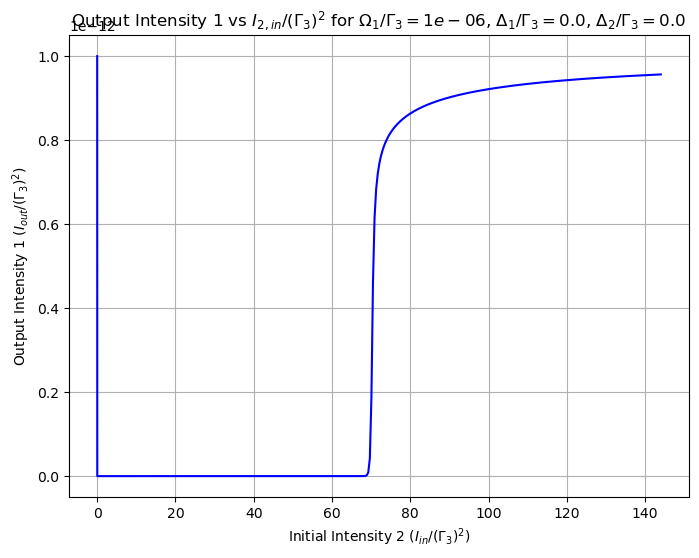

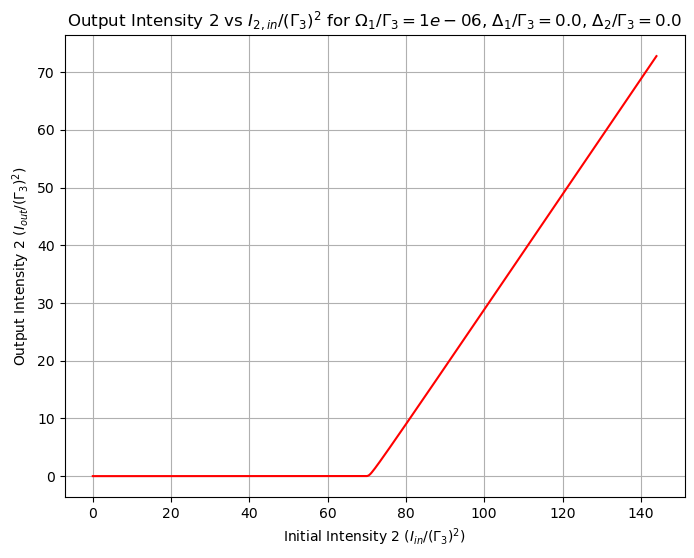

In [14]:
Transparency_Omega_1 = None
Transparency_Omega_2 = None
Om_2_list_adapted = None

# Constants
epsilon_0 = 8.854e-12  # Vacuum permittivity (F/m)
hbar = 1.054e-34       # Reduced Planck's constant (J·s)
mu_13 = 1.932e-29      # Dipole moment between states |1> and |3> (C·m)
mu_23 = 2.53e-29       # Dipole moment between states |2> and |3> (C·m)
N = 3.5e10             # Atomic number density (atoms/m^3)

Gamma3 = 2 * np.pi * 6   # (MHz)
Gamma31 = 5/9 * Gamma3   # Decay from level 3 to level 1 (MHz)
Gamma32 = Gamma23 = 4/9 * Gamma3   # Decay from level 3 to level 2 (MHz)
Gamma12 = Gamma21 = 0.05 * Gamma3    # Decay rates between levels 1 and 2 (MHz)
gamma13 = (Gamma3 + Gamma12)/2  # Decoherence rate between levels 1 and 3 (MHz)
gamma23 = (Gamma3 + Gamma21)/2  # Decoherence rate between levels 2 and 3 (MHz)
gamma12 = (Gamma12 + Gamma21)/2     # Decoherence rate between ground states (MHz)

w_1 = 2 * np.pi * 3e8 / 795e-9
k_0 = w_1 / 3e8
L = 0.1        # Length in meters
z = 0.00001    # Step size in meters

# Backend function to calculate OD based on user input
def calculate_OD_1(Om_1=1.0, delta_1=0.0, delta_2=0.0):
    n_rabi = 500
    Om_2_list_adapted = np.linspace(0.005, 12, n_rabi, dtype=complex)  # Coupling Rabi frequency range (dimensionless)
    Om_2_list = Om_2_list_adapted * Gamma3
    Om_1_list = np.full(n_rabi, Om_1 * Gamma3, dtype=complex)
    
    nz = int(L / z)  # Number of z steps
    z_array = np.arange(nz) * z  # Array of z values
    
    # Initialize arrays to store Rabi frequencies at each z step
    Om_2_vs_z = []
    Om_1_vs_z = []

    # Initialize arrays with zeros to store populations
    rho11_values = np.zeros((nz, n_rabi), dtype=float)
    rho22_values = np.zeros((nz, n_rabi), dtype=float)
    rho33_values = np.zeros((nz, n_rabi), dtype=float)
    
    rho11_values[0, :] = 1.0
    rho22_values[0, :] = 0.0
    rho33_values[0, :] = 0.0

    # Initialize arrays to store rho31 and rho32
    rho31_values = np.zeros((nz, n_rabi), dtype=complex)
    rho32_values = np.zeros((nz, n_rabi), dtype=complex)

    for i in range(nz):
        if i == nz/4 or i == nz/2 or i == 3*nz/4: 
            print(f"Processing z step {i}/{nz}")
        
        for j in range(1, len(Om_2_list)):
            Om_2_actual = Om_2_list[j]      # Convert to actual Omega_2 in MHz
            Om_1_actual = Om_1_list[j]      # Convert Om_1 to MHz

            delta_1_actual = delta_1 * Gamma3
            delta_2_actual = delta_2 * Gamma3

            # Construct A and b as per Code2
            # Define the imaginary unit
            I = 1j

            # Construct the matrix A
            A = np.array([
                # Row 1
                [Gamma31 + Gamma12, 0, I*Om_1_actual/2, 0, Gamma31 - Gamma21, 0, -I*np.conjugate(Om_1_actual)/2, 0],
                # Row 2
                [0, gamma12 - I*(delta_2_actual - delta_1_actual), I*Om_2_actual/2, 0, 0, 0, 0, -I*np.conjugate(Om_1_actual)/2],
                # Row 3
                [I*np.conjugate(Om_1_actual), I*np.conjugate(Om_2_actual)/2, gamma13 + I*delta_1_actual, 0, I*np.conjugate(Om_1_actual)/2, 0, 0, 0],
                # Row 4
                [0, 0, 0, gamma12 + I*(delta_2_actual - delta_1_actual), 0, I*Om_1_actual/2, -I*np.conjugate(Om_2_actual)/2, 0],
                # Row 5
                [Gamma32 - Gamma12, 0, 0, 0, Gamma32 + Gamma21, I*Om_2_actual/2, 0, -I*np.conjugate(Om_2_actual)/2],
                # Row 6
                [I*np.conjugate(Om_2_actual)/2, 0, 0, I*np.conjugate(Om_1_actual)/2, I*np.conjugate(Om_2_actual), gamma23 + I*delta_2_actual, 0, 0],
                # Row 7
                [-I*Om_1_actual, 0, 0, -I*Om_2_actual/2, -I*Om_1_actual/2, 0, gamma13 - I*delta_1_actual, 0],
                # Row 8
                [-I*Om_2_actual/2, -I*Om_1_actual/2, 0, 0, -I*Om_2_actual, 0, 0, gamma23 - I*delta_2_actual]
            ], dtype=complex)
            
            # Construct the vector b
            b = np.array([
                Gamma31,
                0,
                I*np.conjugate(Om_1_actual)/2,
                0,
                Gamma32,
                I*np.conjugate(Om_2_actual)/2,
                -I*Om_1_actual/2,
                -I*Om_2_actual/2
            ], dtype=complex)
            
            # Solve the linear system A * v = b
            try:
                v = np.linalg.solve(A, b)
            except np.linalg.LinAlgError:
                # Handle singular matrix
                print("nan")
                rho11_values[i][j] = np.nan
                rho22_values[i][j] = np.nan
                rho33_values[i][j] = np.nan
                rho31_values[i][j] = np.nan
                rho32_values[i][j] = np.nan
                continue

            # Extract the solutions
            rho11 = np.real(v[0])
            rho12 = v[1]
            rho13 = v[2]
            rho21 = v[3]
            rho22 = np.real(v[4])
            rho23 = v[5]
            rho31 = v[6]
            rho32 = v[7]

            # Compute rho33
            rho33 = 1 - rho11 - rho22

            # Store the populations
            rho11_values[i][j] = np.real(rho11)
            rho22_values[i][j] = np.real(rho22)
            rho33_values[i][j] = np.real(rho33)
            rho31_values[i][j] = rho31
            rho32_values[i][j] = rho32
            

            # Update the Rabi frequencies
            Om_2_list[j] = Om_2_actual + z * (1j) * (k_0 / (epsilon_0 * hbar)) * N * rho32 * mu_23**2
            Om_1_list[j] = Om_1_actual + z * (1j) * (k_0 / (epsilon_0 * hbar)) * N * rho31 * mu_13**2

        # Record Rabi frequencies at this z step
        Om_2_vs_z.append(Om_2_list.copy())
        Om_1_vs_z.append(Om_1_list.copy())
    
    # Convert lists to numpy arrays
    Om_2_vs_z = np.array(Om_2_vs_z)  # Shape: (nz, n_rabi)
    Om_1_vs_z = np.array(Om_1_vs_z)
    
    return Om_2_list_adapted, Om_2_list, Om_1_list, rho11_values, rho22_values, rho33_values, rho31_values, rho32_values, Om_2_vs_z, Om_1_vs_z, z_array

def plot_OD(Om_1, delta_1, delta_2):
    global Transparency_Omega_1, Transparency_Omega_2, Om_2_list_adapted
    Om_2_list_adapted, Om_2_list, Om_1_list, rho11_values, rho22_values, rho33_values, rho31_values, rho32_values, Om_2_vs_z, Om_1_vs_z, z_array = calculate_OD_1(Om_1, delta_1, delta_2)
   
    Om_2_vs_z_dimensionless = Om_2_vs_z / Gamma3
    Om_1_vs_z_dimensionless = Om_1_vs_z / Gamma3
    
    # Compute transparency for Omega_1 and Omega_2
    Transparency_Omega_1 = np.abs(Om_1_vs_z[-1, :])**2 / np.abs(Om_1_vs_z[0, :])**2
    Transparency_Omega_2 = np.abs(Om_2_vs_z[-1, :])**2 / np.abs(Om_2_vs_z[0, :])**2

    # Calculate output intensity based on transparency and initial input power
    Output_Intensity_Omega_1 = Transparency_Omega_1 * np.abs(Om_1_vs_z[0, :])**2 / (Gamma3**2)
    Output_Intensity_Omega_2 = Transparency_Omega_2 * np.abs(Om_2_vs_z[0, :])**2 / (Gamma3**2)
    
    # Plot Output Intensity of Omega_1 vs Initial Omega_2
    plt.figure(figsize=(8, 6))
    plt.plot(np.real(Om_2_list_adapted)**2, Output_Intensity_Omega_1, color='blue', label='Output Intensity $\Omega_1$')
    plt.xlabel('Initial Intensity 2 ($I_{in} / (\\Gamma_3)^2$)')
    plt.ylabel('Output Intensity 1 ($I_{out} / (\\Gamma_3)^2$)')
    plt.title(f'Output Intensity 1 vs $I_{{2,\t{{in}}}} / (\\Gamma_3)^2$ for 'f'$\\Omega_1/\\Gamma_3={Om_1}$, 'f'$\\Delta_1/\\Gamma_3={delta_1}$, 'f'$\\Delta_2/\\Gamma_3={delta_2}$')
    plt.grid(True)
    plt.show()

    # Plot Output Intensity of Omega_2 vs Initial Omega_2
    plt.figure(figsize=(8, 6))
    plt.plot(np.real(Om_2_list_adapted)**2, Output_Intensity_Omega_2, color='red', label='Output Intensity $\Omega_2$')
    plt.xlabel('Initial Intensity 2 ($I_{in} / (\\Gamma_3)^2$)')
    plt.ylabel('Output Intensity 2 ($I_{out} / (\\Gamma_3)^2$)')
    plt.title(f'Output Intensity 2 vs $I_{{2,\t{{in}}}} / (\\Gamma_3)^2$ for 'f'$\\Omega_1/\\Gamma_3={Om_1}$, 'f'$\\Delta_1/\\Gamma_3={delta_1}$, 'f'$\\Delta_2/\\Gamma_3={delta_2}$')
    plt.grid(True)
    plt.show()

# Adjust slider description width specifically
slider_layout = widgets.Layout(width='800px')  # Adjust slider width if needed
description_layout = widgets.Layout(width='150px')  # Adjust description width

# Interactive sliders for Om_1, delta_1, delta_2 with wider description layout
Om_1_slider = widgets.FloatSlider(
    value=3, min=0.000001, max=10.0, step=0.01,
    description='$\Omega_1$ (MHz)', layout=slider_layout,
    style={'description_width': '150px'}  # This sets description width
)

delta_1_slider = widgets.FloatSlider(
    value=0.50, min=-1.5, max=1.5, step=0.01,
    description='$\Delta_1$ (MHz)', layout=slider_layout,
    style={'description_width': '150px'}  # Adjust description width
)

delta_2_slider = widgets.FloatSlider(
    value=0.0, min=-1.5, max=1.5, step=0.01,
    description='$\Delta_2$ (MHz)', layout=slider_layout,
    style={'description_width': '150px'}  # Adjust description width
)

# Create the button to start the simulation
run_button = widgets.Button(
    description="Run Simulation",
    button_style='success',  # 'success', 'info', 'warning', 'danger' or '' (default)
    tooltip='Click to run the simulation',
    icon='play'
)

# Function to be triggered when the button is clicked
def run_simulation(b):
    # Extract the current slider values
    Om_1 = Om_1_slider.value
    delta_1 = delta_1_slider.value
    delta_2 = delta_2_slider.value
    
    # Call the plot_OD function with these values
    plot_OD(Om_1, delta_1, delta_2)

# Attach the function to the button
run_button.on_click(run_simulation)

# Display the sliders and the button
display(Om_1_slider, delta_1_slider, delta_2_slider, run_button)


In [13]:
Transparency_Omega_1 = None
Transparency_Omega_2 = None
Om_1_list_adapted = None

# Constants
epsilon_0 = 8.854e-12  # Vacuum permittivity (F/m)
hbar = 1.054e-34       # Reduced Planck's constant (J·s)
mu_13 = 1.932e-29      # Dipole moment between states |1> and |3> (C·m)
mu_23 = 2.53e-29       # Dipole moment between states |2> and |3> (C·m)
N = 3.5e10             # Atomic number density (atoms/m^3)

Gamma3 = 2 * np.pi * 6   # (MHz)
Gamma31 = 5/9 * Gamma3   # Decay from level 3 to level 1 (MHz)
Gamma32 = Gamma23 = 4/9 * Gamma3   # Decay from level 3 to level 2 (MHz)
Gamma12 = Gamma21 = 0.5 * Gamma3    # Decay rates between levels 1 and 2 (MHz)
gamma13 = (Gamma3 + Gamma12)/2  # Decoherence rate between levels 1 and 3 (MHz)
gamma23 = (Gamma3 + Gamma21)/2  # Decoherence rate between levels 2 and 3 (MHz)
gamma12 = (Gamma12 + Gamma21)/2     # Decoherence rate between ground states (MHz)


w_1 = 2 * np.pi * 3e8 / 795e-9
k_0 = w_1 / 3e8
L = 0.1        # Length in meters
z = 0.00001    # Step size in meters

# Backend function to calculate OD based on user input
def calculate_OD_1(Om_2=1.0, delta_1=0.0, delta_2=0.0):
    n_rabi = 500
    Om_1_list_adapted = np.linspace(0.005, 12, n_rabi, dtype=complex)  # Probe Rabi frequency range (dimensionless)
    Om_1_list = Om_1_list_adapted * Gamma3
    Om_2_list = np.full(n_rabi, Om_2 * Gamma3, dtype=complex)
    
    nz = int(L / z)  # Number of z steps
    z_array = np.arange(nz) * z  # Array of z values
    
    # Initialize arrays to store Rabi frequencies at each z step
    Om_1_vs_z = []
    Om_2_vs_z = []
    
    # Initialize arrays with zeros to store populations
    rho11_values = np.zeros((nz, n_rabi), dtype=float)
    rho22_values = np.zeros((nz, n_rabi), dtype=float)
    rho33_values = np.zeros((nz, n_rabi), dtype=float)
    
    rho11_values[0, :] = 1.0
    rho22_values[0, :] = 0.0
    rho33_values[0, :] = 0.0

    # Initialize arrays to store rho31 and rho32
    rho31_values = np.zeros((nz, n_rabi), dtype=complex)
    rho32_values = np.zeros((nz, n_rabi), dtype=complex)
    
    for i in range(nz):
        if i == nz/4 or i == nz/2 or i == 3*nz/4: 
            print(f"Processing z step {i}/{nz}")
        
        for j in range(1, len(Om_1_list)):
            Om_1_actual = Om_1_list[j]      # Convert to actual Omega_1 in MHz
            Om_2_actual = Om_2_list[j]      # Convert Om_2 to MHz

            delta_1_actual = delta_1 * Gamma3
            delta_2_actual = delta_2 * Gamma3

            # Construct A and b as per Code2
            # Define the imaginary unit
            I = 1j

            # Construct the matrix A
            A = np.array([
                # Row 1
                [Gamma31 + Gamma12, 0, I*Om_1_actual/2, 0, Gamma31 - Gamma21, 0, -I*np.conjugate(Om_1_actual)/2, 0],
                # Row 2
                [0, gamma12 - I*(delta_2_actual - delta_1_actual), I*Om_2_actual/2, 0, 0, 0, 0, -I*np.conjugate(Om_1_actual)/2],
                # Row 3
                [I*np.conjugate(Om_1_actual), I*np.conjugate(Om_2_actual)/2, gamma13 + I*delta_1_actual, 0, I*np.conjugate(Om_1_actual)/2, 0, 0, 0],
                # Row 4
                [0, 0, 0, gamma12 + I*(delta_2_actual - delta_1_actual), 0, I*Om_1_actual/2, -I*np.conjugate(Om_2_actual)/2, 0],
                # Row 5
                [Gamma32 - Gamma12, 0, 0, 0, Gamma32 + Gamma21, I*Om_2_actual/2, 0, -I*np.conjugate(Om_2_actual)/2],
                # Row 6
                [I*np.conjugate(Om_2_actual)/2, 0, 0, I*np.conjugate(Om_1_actual)/2, I*np.conjugate(Om_2_actual), gamma23 + I*delta_2_actual, 0, 0],
                # Row 7
                [-I*Om_1_actual, 0, 0, -I*Om_2_actual/2, -I*Om_1_actual/2, 0, gamma13 - I*delta_1_actual, 0],
                # Row 8
                [-I*Om_2_actual/2, -I*Om_1_actual/2, 0, 0, -I*Om_2_actual, 0, 0, gamma23 - I*delta_2_actual]
            ], dtype=complex)
            
            # Construct the vector b
            b = np.array([
                Gamma31,
                0,
                I*np.conjugate(Om_1_actual)/2,
                0,
                Gamma32,
                I*np.conjugate(Om_2_actual)/2,
                -I*Om_1_actual/2,
                -I*Om_2_actual/2
            ], dtype=complex)

            # Solve the linear system A * v = b
            try:
                v = np.linalg.solve(A, b)
            except np.linalg.LinAlgError:
                # Handle singular matrix
                print("nan")
                rho11_values[i][j] = np.nan
                rho22_values[i][j] = np.nan
                rho33_values[i][j] = np.nan
                rho31_values[i][j] = np.nan
                rho32_values[i][j] = np.nan
                continue

            # Extract the solutions
            rho11 = np.real(v[0])
            rho12 = v[1]
            rho13 = v[2]
            rho21 = v[3]
            rho22 = np.real(v[4])
            rho23 = v[5]
            rho31 = v[6]
            rho32 = v[7]

            # Compute rho33
            rho33 = 1 - rho11 - rho22

            # Store the populations
            rho11_values[i][j] = np.real(rho11)
            rho22_values[i][j] = np.real(rho22)
            rho33_values[i][j] = np.real(rho33)
            rho31_values[i][j] = rho31
            rho32_values[i][j] = rho32

            # Update the Rabi frequencies
            Om_1_list[j] = Om_1_actual + z * (1j) * (k_0 / (epsilon_0 * hbar)) * N * rho31 * mu_13**2
            Om_2_list[j] = Om_2_actual + z * (1j) * (k_0 / (epsilon_0 * hbar)) * N * rho32 * mu_23**2

        # Record Rabi frequencies at this z step
        Om_1_vs_z.append(Om_1_list.copy())
        Om_2_vs_z.append(Om_2_list.copy())
    
    # Convert lists to numpy arrays
    Om_1_vs_z = np.array(Om_1_vs_z)  # Shape: (nz, n_rabi)
    Om_2_vs_z = np.array(Om_2_vs_z)
    
    return Om_1_list_adapted, Om_1_list, Om_2_list, rho11_values, rho22_values, rho33_values, rho31_values, rho32_values, Om_1_vs_z, Om_2_vs_z, z_array

def plot_OD(Om_2, delta_1, delta_2):
    global Transparency_Omega_1, Transparency_Omega_2, Om_1_list_adapted
    Om_1_list_adapted, Om_1_list, Om_2_list, rho11_values, rho22_values, rho33_values, rho31_values, rho32_values, Om_1_vs_z, Om_2_vs_z, z_array = calculate_OD_1(Om_2, delta_1, delta_2)
   
    Om_1_vs_z_dimensionless = Om_1_vs_z / Gamma3
    Om_2_vs_z_dimensionless = Om_2_vs_z / Gamma3
    
    # Compute transparency for Omega_1 and Omega_2
    Transparency_Omega_1 = np.abs(Om_1_vs_z[-1, :])**2 / np.abs(Om_1_vs_z[0, :])**2
    Transparency_Omega_2 = np.abs(Om_2_vs_z[-1, :])**2 / np.abs(Om_2_vs_z[0, :])**2

    # Calculate output intensity based on transparency and initial input power
    Output_Intensity_Omega_1 = Transparency_Omega_1 * np.abs(Om_1_vs_z[0, :])**2 / (Gamma3**2)
    Output_Intensity_Omega_2 = Transparency_Omega_2 * np.abs(Om_2_vs_z[0, :])**2 / (Gamma3**2)
    
    # Plot Output Intensity of Omega_1 vs Initial Omega_1
    plt.figure(figsize=(8, 6))
    plt.plot(np.real(Om_1_list_adapted)**2, Output_Intensity_Omega_1, color='blue', label='Output Intensity $\Omega_1$')
    plt.xlabel('Initial Intensity 1 ($I_{in} / (\\Gamma_3)^2$)')
    plt.ylabel('Output Intensity 1 ($I_{out} / (\\Gamma_3)^2$)')
    plt.title(f'Output Intensity 1 vs $I_{{1,\t{{in}}}} / (\\Gamma_3)^2$ for 'f'$\\Omega_2/\\Gamma_3={Om_2}$, 'f'$\\Delta_1/\\Gamma_3={delta_1}$, 'f'$\\Delta_2/\\Gamma_3={delta_2}$')
    plt.grid(True)
    plt.show()

    # Plot Output Intensity of Omega_2 vs Initial Omega_1
    plt.figure(figsize=(8, 6))
    plt.plot(np.real(Om_1_list_adapted)**2, Output_Intensity_Omega_2, color='red', label='Output Intensity $\Omega_2$')
    plt.xlabel('Initial Intensity 1 ($I_{in} / (\\Gamma_3)^2$)')
    plt.ylabel('Output Intensity 2 ($I_{out} / (\\Gamma_3)^2$)')
    plt.title(f'Output Intensity 2 vs $I_{{1,\t{{in}}}} / (\\Gamma_3)^2$ for 'f'$\\Omega_2/\\Gamma_3={Om_2}$, 'f'$\\Delta_1/\\Gamma_3={delta_1}$, 'f'$\\Delta_2/\\Gamma_3={delta_2}$')
    plt.grid(True)
    plt.show()

# Adjust slider description width specifically
slider_layout = widgets.Layout(width='800px')  # Adjust slider width if needed
description_layout = widgets.Layout(width='150px')  # Adjust description width

# Interactive sliders for Om_2, delta_1, delta_2 with wider description layout
Om_2_slider = widgets.FloatSlider(
    value=3, min=0.000001, max=10.0, step=0.01,
    description='$\Omega_2$ (MHz)', layout=slider_layout,
    style={'description_width': '150px'}  # This sets description width
)

delta_1_slider = widgets.FloatSlider(
    value=0.50, min=-1.5, max=1.5, step=0.01,
    description='$\Delta_1$ (MHz)', layout=slider_layout,
    style={'description_width': '150px'}  # Adjust description width
)

delta_2_slider = widgets.FloatSlider(
    value=0.0, min=-1.5, max=1.5, step=0.01,
    description='$\Delta_2$ (MHz)', layout=slider_layout,
    style={'description_width': '150px'}  # Adjust description width
)

# Create the button to start the simulation
run_button = widgets.Button(
    description="Run Simulation",
    button_style='success',  # 'success', 'info', 'warning', 'danger' or '' (default)
    tooltip='Click to run the simulation',
    icon='play'
)

# Function to be triggered when the button is clicked
def run_simulation(b):
    # Extract the current slider values
    Om_2 = Om_2_slider.value
    delta_1 = delta_1_slider.value
    delta_2 = delta_2_slider.value
    
    # Call the plot_OD function with these values
    plot_OD(Om_2, delta_1, delta_2)

# Attach the function to the button
run_button.on_click(run_simulation)

# Display the sliders and the button
display(Om_2_slider, delta_1_slider, delta_2_slider, run_button)

FloatSlider(value=3.0, description='$\\Omega_2$ (MHz)', layout=Layout(width='800px'), max=10.0, min=1e-06, ste…

FloatSlider(value=0.5, description='$\\Delta_1$ (MHz)', layout=Layout(width='800px'), max=1.5, min=-1.5, step=…

FloatSlider(value=0.0, description='$\\Delta_2$ (MHz)', layout=Layout(width='800px'), max=1.5, min=-1.5, step=…

Button(button_style='success', description='Run Simulation', icon='play', style=ButtonStyle(), tooltip='Click …

# Scanning Values

Button(button_style='success', description='Run Simulation', icon='play', style=ButtonStyle(), tooltip='Click …

Processing z step 2500/10000
Processing z step 5000/10000
Processing z step 7500/10000
Processing z step 2500/10000
Processing z step 5000/10000
Processing z step 7500/10000
Processing z step 2500/10000
Processing z step 5000/10000
Processing z step 7500/10000
Processing z step 2500/10000
Processing z step 5000/10000
Processing z step 7500/10000
Processing z step 2500/10000
Processing z step 5000/10000
Processing z step 7500/10000


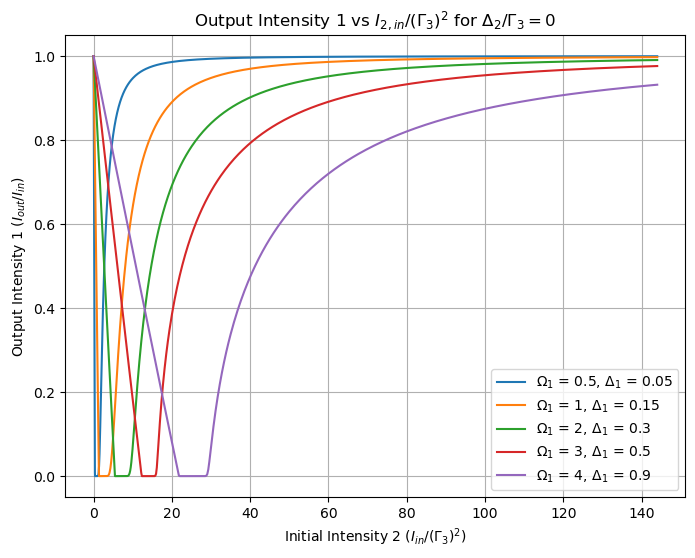

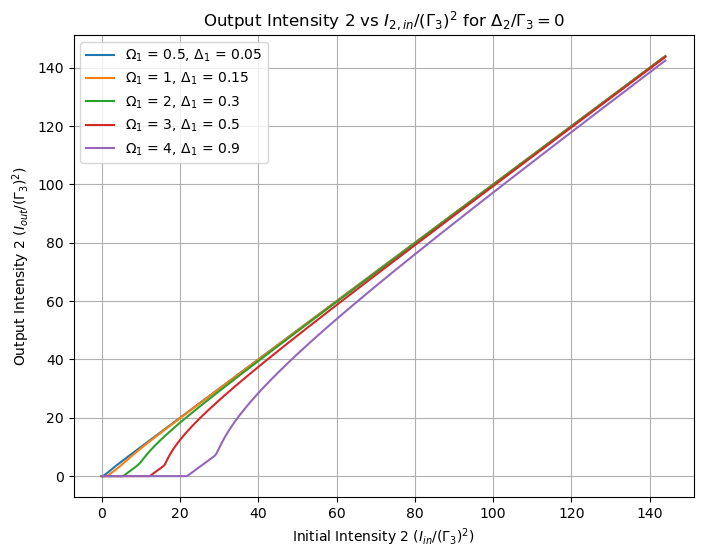

In [46]:
Transparency_Omega_1 = None
Transparency_Omega_2 = None
Om_2_list_adapted = None

# Constants
epsilon_0 = 8.854e-12  # Vacuum permittivity (F/m)
hbar = 1.054e-34       # Reduced Planck's constant (J·s)
mu_13 = 1.932e-29      # Dipole moment between states |1> and |3> (C·m)
mu_23 = 2.53e-29       # Dipole moment between states |2> and |3> (C·m)
N = 3.5e10             # Atomic number density (atoms/m^3)

Gamma3 = 2 * np.pi * 6   # (MHz)
Gamma31 = 5/9 * Gamma3   # Decay from level 3 to level 1 (MHz)
Gamma32 = Gamma23 = 4/9 * Gamma3   # Decay from level 3 to level 2 (MHz)
Gamma12 = Gamma21 = 0.0000001 * Gamma3    # Decay rates between levels 1 and 2 (MHz)
gamma13 = (Gamma3 + Gamma12)/2  # Decoherence rate between levels 1 and 3 (MHz)
gamma23 = (Gamma3 + Gamma21)/2  # Decoherence rate between levels 2 and 3 (MHz)
gamma12 = (Gamma12 + Gamma21)/2     # Decoherence rate between ground states (MHz)

w_1 = 2 * np.pi * 3e8 / 795e-9
k_0 = w_1 / 3e8
L = 0.1        # Length in meters
z = 0.00001    # Step size in meters

# Backend function to calculate OD based on user input
def calculate_OD_1(Om_1=1.0, delta_1=0.0, delta_2=0.0):
    n_rabi = 500
    Om_2_list_adapted = np.linspace(0.005, 12, n_rabi, dtype=complex)  # Coupling Rabi frequency range (dimensionless)
    Om_2_list = Om_2_list_adapted * Gamma3
    Om_1_list = np.full(n_rabi, Om_1 * Gamma3, dtype=complex)
    
    nz = int(L / z)  # Number of z steps
    z_array = np.arange(nz) * z  # Array of z values
    
    # Initialize arrays to store Rabi frequencies at each z step
    Om_2_vs_z = []
    Om_1_vs_z = []

    # Initialize arrays with zeros to store populations
    rho11_values = np.zeros((nz, n_rabi), dtype=float)
    rho22_values = np.zeros((nz, n_rabi), dtype=float)
    rho33_values = np.zeros((nz, n_rabi), dtype=float)
    
    rho11_values[0, :] = 0.5
    rho22_values[0, :] = 0.5
    rho33_values[0, :] = 0.0

    # Initialize arrays to store rho31 and rho32
    rho31_values = np.zeros((nz, n_rabi), dtype=complex)
    rho32_values = np.zeros((nz, n_rabi), dtype=complex)

    for i in range(nz):
        if i == nz/4 or i == nz/2 or i == 3*nz/4: 
            print(f"Processing z step {i}/{nz}")
        
        for j in range(1, len(Om_2_list)):
            Om_2_actual = Om_2_list[j]      # Convert to actual Omega_2 in MHz
            Om_1_actual = Om_1_list[j]      # Convert Om_1 to MHz

            delta_1_actual = delta_1 * Gamma3
            delta_2_actual = delta_2 * Gamma3

            # Construct A and b as per Code2
            # Define the imaginary unit
            I = 1j

            # Construct the matrix A
            A = np.array([
                # Row 1
                [Gamma31 + Gamma12, 0, I*Om_1_actual/2, 0, Gamma31 - Gamma21, 0, -I*np.conjugate(Om_1_actual)/2, 0],
                # Row 2
                [0, gamma12 - I*(delta_2_actual - delta_1_actual), I*Om_2_actual/2, 0, 0, 0, 0, -I*np.conjugate(Om_1_actual)/2],
                # Row 3
                [I*np.conjugate(Om_1_actual), I*np.conjugate(Om_2_actual)/2, gamma13 + I*delta_1_actual, 0, I*np.conjugate(Om_1_actual)/2, 0, 0, 0],
                # Row 4
                [0, 0, 0, gamma12 + I*(delta_2_actual - delta_1_actual), 0, I*Om_1_actual/2, -I*np.conjugate(Om_2_actual)/2, 0],
                # Row 5
                [Gamma32 - Gamma12, 0, 0, 0, Gamma32 + Gamma21, I*Om_2_actual/2, 0, -I*np.conjugate(Om_2_actual)/2],
                # Row 6
                [I*np.conjugate(Om_2_actual)/2, 0, 0, I*np.conjugate(Om_1_actual)/2, I*np.conjugate(Om_2_actual), gamma23 + I*delta_2_actual, 0, 0],
                # Row 7
                [-I*Om_1_actual, 0, 0, -I*Om_2_actual/2, -I*Om_1_actual/2, 0, gamma13 - I*delta_1_actual, 0],
                # Row 8
                [-I*Om_2_actual/2, -I*Om_1_actual/2, 0, 0, -I*Om_2_actual, 0, 0, gamma23 - I*delta_2_actual]
            ], dtype=complex)
            
            # Construct the vector b
            b = np.array([
                Gamma31,
                0,
                I*np.conjugate(Om_1_actual)/2,
                0,
                Gamma32,
                I*np.conjugate(Om_2_actual)/2,
                -I*Om_1_actual/2,
                -I*Om_2_actual/2
            ], dtype=complex)
            
            # Solve the linear system A * v = b
            try:
                v = np.linalg.solve(A, b)
            except np.linalg.LinAlgError:
                # Handle singular matrix
                print("nan")
                rho11_values[i][j] = np.nan
                rho22_values[i][j] = np.nan
                rho33_values[i][j] = np.nan
                rho31_values[i][j] = np.nan
                rho32_values[i][j] = np.nan
                continue

            # Extract the solutions
            rho11 = np.real(v[0])
            rho12 = v[1]
            rho13 = v[2]
            rho21 = v[3]
            rho22 = np.real(v[4])
            rho23 = v[5]
            rho31 = v[6]
            rho32 = v[7]

            # Compute rho33
            rho33 = 1 - rho11 - rho22

            # Store the populations
            rho11_values[i][j] = np.real(rho11)
            rho22_values[i][j] = np.real(rho22)
            rho33_values[i][j] = np.real(rho33)
            rho31_values[i][j] = rho31
            rho32_values[i][j] = rho32
            

            # Update the Rabi frequencies
            Om_2_list[j] = Om_2_actual + z * (1j) * (k_0 / (epsilon_0 * hbar)) * N * rho32 * mu_23**2
            Om_1_list[j] = Om_1_actual + z * (1j) * (k_0 / (epsilon_0 * hbar)) * N * rho31 * mu_13**2

        # Record Rabi frequencies at this z step
        Om_2_vs_z.append(Om_2_list.copy())
        Om_1_vs_z.append(Om_1_list.copy())
    
    # Convert lists to numpy arrays
    Om_2_vs_z = np.array(Om_2_vs_z)  # Shape: (nz, n_rabi)
    Om_1_vs_z = np.array(Om_1_vs_z)
    
    return Om_2_list_adapted, Om_2_list, Om_1_list, rho11_values, rho22_values, rho33_values, rho31_values, rho32_values, Om_2_vs_z, Om_1_vs_z, z_array

def plot_OD(Om_1: list,delta_1: list, delta_2):
    global Transparency_Omega_1, Transparency_Omega_2, Om_2_list_adapted
    Output_Intensity_Omega_1 = []
    Output_Intensity_Omega_2 = []
    
    for i in range(len(Om_1)):
        Om_2_list_adapted, Om_2_list, Om_1_list, rho11_values, rho22_values, rho33_values, rho31_values, rho32_values, Om_2_vs_z, Om_1_vs_z, z_array = calculate_OD_1(Om_1[i], delta_1[i], delta_2)
    
        # Compute transparency for Omega_1 and Omega_2
        Transparency_Omega_1 = np.abs(Om_1_vs_z[-1, :])**2 / np.abs(Om_1_vs_z[0, :])**2
        Transparency_Omega_2 = np.abs(Om_2_vs_z[-1, :])**2 / np.abs(Om_2_vs_z[0, :])**2

        # Calculate output intensity based on transparency and initial input power
        #Output_Intensity_Omega_1.append(Transparency_Omega_1 * np.abs(Om_1_vs_z[0, :])**2 / (Gamma3**2))
        Output_Intensity_Omega_1.append(Transparency_Omega_1)
        Output_Intensity_Omega_2.append(Transparency_Omega_2 * np.abs(Om_2_vs_z[0, :])**2 / (Gamma3**2))
    

    # Plot Output Intensity of Omega_1 vs Initial Omega_2
    plt.figure(figsize=(8, 6))
    for i in range(len(Om_1)):
        plt.plot(np.real(Om_2_list_adapted)**2, Output_Intensity_Omega_1[i], label=f'$\Omega_1$ = {Om_1[i]}, $\Delta_1$ = {delta_1[i]}')
        
    plt.xlabel('Initial Intensity 2 ($I_{in} / (\\Gamma_3)^2$)')
    plt.ylabel('Output Intensity 1 ($I_{out} / I_{in}$)')
    plt.title(f'Output Intensity 1 vs $I_{{2,\t{{in}}}} / (\\Gamma_3)^2$ for 'f'$\\Delta_2/\\Gamma_3={delta_2}$')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot Output Intensity of Omega_2 vs Initial Omega_2
    plt.figure(figsize=(8, 6))
    for i in range(len(Om_1)):
        plt.plot(np.real(Om_2_list_adapted)**2, Output_Intensity_Omega_2[i], label=f'$\Omega_1$ = {Om_1[i]}, $\Delta_1$ = {delta_1[i]}')
    plt.xlabel('Initial Intensity 2 ($I_{in} / (\\Gamma_3)^2$)')
    plt.ylabel('Output Intensity 2 ($I_{out} / (\\Gamma_3)^2$)')
    plt.title(f'Output Intensity 2 vs $I_{{2,\t{{in}}}} / (\\Gamma_3)^2$ for 'f'$\\Delta_2/\\Gamma_3={delta_2}$')
    plt.grid(True)
    plt.legend()
    plt.show()


# Create the button to start the simulation
run_button = widgets.Button(
    description="Run Simulation",
    button_style='success',  # 'success', 'info', 'warning', 'danger' or '' (default)
    tooltip='Click to run the simulation',
    icon='play'
)

# Function to be triggered when the button is clicked
def run_simulation(b):
    # Extract the current slider values
    Om_1 = [0.5, 1, 2, 3, 4]
    delta_1 = [0.05, 0.15, 0.3, 0.5, 0.9]
    delta_2 = 0
    
    # Call the plot_OD function with these values
    plot_OD(Om_1, delta_1, delta_2)

# Attach the function to the button
run_button.on_click(run_simulation)

# Display the sliders and the button
display(run_button)


In [45]:
Transparency_Omega_1 = None
Transparency_Omega_2 = None
Om_1_list_adapted = None

# Constants
epsilon_0 = 8.854e-12  # Vacuum permittivity (F/m)
hbar = 1.054e-34       # Reduced Planck's constant (J·s)
mu_13 = 1.932e-29      # Dipole moment between states |1> and |3> (C·m)
mu_23 = 2.53e-29       # Dipole moment between states |2> and |3> (C·m)
N = 3.5e10             # Atomic number density (atoms/m^3)

Gamma3 = 2 * np.pi * 6   # (MHz)
Gamma31 = 5/9 * Gamma3   # Decay from level 3 to level 1 (MHz)
Gamma32 = Gamma23 = 4/9 * Gamma3   # Decay from level 3 to level 2 (MHz)
Gamma12 = Gamma21 = 0.0000001 * Gamma3    # Decay rates between levels 1 and 2 (MHz)
gamma13 = (Gamma3 + Gamma12)/2  # Decoherence rate between levels 1 and 3 (MHz)
gamma23 = (Gamma3 + Gamma21)/2  # Decoherence rate between levels 2 and 3 (MHz)
gamma12 = (Gamma12 + Gamma21)/2     # Decoherence rate between ground states (MHz)


w_1 = 2 * np.pi * 3e8 / 795e-9
k_0 = w_1 / 3e8
L = 0.1        # Length in meters
z = 0.00001    # Step size in meters

# Backend function to calculate OD based on user input
def calculate_OD_1(Om_2=1.0, delta_1=0.0, delta_2=0.0):
    n_rabi = 500
    Om_1_list_adapted = np.linspace(0.005, 12, n_rabi, dtype=complex)  # Probe Rabi frequency range (dimensionless)
    Om_1_list = Om_1_list_adapted * Gamma3
    Om_2_list = np.full(n_rabi, Om_2 * Gamma3, dtype=complex)
    
    nz = int(L / z)  # Number of z steps
    z_array = np.arange(nz) * z  # Array of z values
    
    # Initialize arrays to store Rabi frequencies at each z step
    Om_1_vs_z = []
    Om_2_vs_z = []
    
    # Initialize arrays with zeros to store populations
    rho11_values = np.zeros((nz, n_rabi), dtype=float)
    rho22_values = np.zeros((nz, n_rabi), dtype=float)
    rho33_values = np.zeros((nz, n_rabi), dtype=float)
    
    rho11_values[0, :] = 0.5
    rho22_values[0, :] = 0.5
    rho33_values[0, :] = 0.0

    # Initialize arrays to store rho31 and rho32
    rho31_values = np.zeros((nz, n_rabi), dtype=complex)
    rho32_values = np.zeros((nz, n_rabi), dtype=complex)
    
    for i in range(nz):
        if i == nz/4 or i == nz/2 or i == 3*nz/4: 
            print(f"Processing z step {i}/{nz}")
        
        for j in range(1, len(Om_1_list)):
            Om_1_actual = Om_1_list[j]      # Convert to actual Omega_1 in MHz
            Om_2_actual = Om_2_list[j]      # Convert Om_2 to MHz

            delta_1_actual = delta_1 * Gamma3
            delta_2_actual = delta_2 * Gamma3

            # Construct A and b as per Code2
            # Define the imaginary unit
            I = 1j

            # Construct the matrix A
            A = np.array([
                # Row 1
                [Gamma31 + Gamma12, 0, I*Om_1_actual/2, 0, Gamma31 - Gamma21, 0, -I*np.conjugate(Om_1_actual)/2, 0],
                # Row 2
                [0, gamma12 - I*(delta_2_actual - delta_1_actual), I*Om_2_actual/2, 0, 0, 0, 0, -I*np.conjugate(Om_1_actual)/2],
                # Row 3
                [I*np.conjugate(Om_1_actual), I*np.conjugate(Om_2_actual)/2, gamma13 + I*delta_1_actual, 0, I*np.conjugate(Om_1_actual)/2, 0, 0, 0],
                # Row 4
                [0, 0, 0, gamma12 + I*(delta_2_actual - delta_1_actual), 0, I*Om_1_actual/2, -I*np.conjugate(Om_2_actual)/2, 0],
                # Row 5
                [Gamma32 - Gamma12, 0, 0, 0, Gamma32 + Gamma21, I*Om_2_actual/2, 0, -I*np.conjugate(Om_2_actual)/2],
                # Row 6
                [I*np.conjugate(Om_2_actual)/2, 0, 0, I*np.conjugate(Om_1_actual)/2, I*np.conjugate(Om_2_actual), gamma23 + I*delta_2_actual, 0, 0],
                # Row 7
                [-I*Om_1_actual, 0, 0, -I*Om_2_actual/2, -I*Om_1_actual/2, 0, gamma13 - I*delta_1_actual, 0],
                # Row 8
                [-I*Om_2_actual/2, -I*Om_1_actual/2, 0, 0, -I*Om_2_actual, 0, 0, gamma23 - I*delta_2_actual]
            ], dtype=complex)
            
            # Construct the vector b
            b = np.array([
                Gamma31,
                0,
                I*np.conjugate(Om_1_actual)/2,
                0,
                Gamma32,
                I*np.conjugate(Om_2_actual)/2,
                -I*Om_1_actual/2,
                -I*Om_2_actual/2
            ], dtype=complex)

            # Solve the linear system A * v = b
            try:
                v = np.linalg.solve(A, b)
            except np.linalg.LinAlgError:
                # Handle singular matrix
                print("nan")
                rho11_values[i][j] = np.nan
                rho22_values[i][j] = np.nan
                rho33_values[i][j] = np.nan
                rho31_values[i][j] = np.nan
                rho32_values[i][j] = np.nan
                continue

            # Extract the solutions
            rho11 = np.real(v[0])
            rho12 = v[1]
            rho13 = v[2]
            rho21 = v[3]
            rho22 = np.real(v[4])
            rho23 = v[5]
            rho31 = v[6]
            rho32 = v[7]

            # Compute rho33
            rho33 = 1 - rho11 - rho22

            # Store the populations
            rho11_values[i][j] = np.real(rho11)
            rho22_values[i][j] = np.real(rho22)
            rho33_values[i][j] = np.real(rho33)
            rho31_values[i][j] = rho31
            rho32_values[i][j] = rho32

            # Update the Rabi frequencies
            Om_1_list[j] = Om_1_actual + z * (1j) * (k_0 / (epsilon_0 * hbar)) * N * rho31 * mu_13**2
            Om_2_list[j] = Om_2_actual + z * (1j) * (k_0 / (epsilon_0 * hbar)) * N * rho32 * mu_23**2

        # Record Rabi frequencies at this z step
        Om_1_vs_z.append(Om_1_list.copy())
        Om_2_vs_z.append(Om_2_list.copy())
    
    # Convert lists to numpy arrays
    Om_1_vs_z = np.array(Om_1_vs_z)  # Shape: (nz, n_rabi)
    Om_2_vs_z = np.array(Om_2_vs_z)
    
    return Om_1_list_adapted, Om_1_list, Om_2_list, rho11_values, rho22_values, rho33_values, rho31_values, rho32_values, Om_1_vs_z, Om_2_vs_z, z_array

def plot_OD(Om_2, delta_1, delta_2):
    
    global Transparency_Omega_1, Transparency_Omega_2, Om_1_list_adapted
    Output_Intensity_Omega_1 = []
    Output_Intensity_Omega_2 = []
    
    for i in range(len(Om_2)):
        Om_1_list_adapted, Om_1_list, Om_2_list, rho11_values, rho22_values, rho33_values, rho31_values, rho32_values, Om_1_vs_z, Om_2_vs_z, z_array = calculate_OD_1(Om_2[i], delta_1[i], delta_2)
    
        # Compute transparency for Omega_1 and Omega_2
        Transparency_Omega_1 = np.abs(Om_1_vs_z[-1, :])**2 / np.abs(Om_1_vs_z[0, :])**2
        Transparency_Omega_2 = np.abs(Om_2_vs_z[-1, :])**2 / np.abs(Om_2_vs_z[0, :])**2

        # Calculate output intensity based on transparency and initial input power
        Output_Intensity_Omega_1.append(Transparency_Omega_1 * np.abs(Om_1_vs_z[0, :])**2 / (Gamma3**2))
        Output_Intensity_Omega_2.append(Transparency_Omega_2)
        #Output_Intensity_Omega_2.append(Transparency_Omega_2 * np.abs(Om_2_vs_z[0, :])**2 / (Gamma3**2))
    
    # Plot Output Intensity of Omega_1 vs Initial Omega_1
    plt.figure(figsize=(8, 6))
    for i in range(len(Om_2)):
        plt.plot(np.real(Om_1_list_adapted)**2, Output_Intensity_Omega_1[i], label=f'$\Omega_2$ = {Om_2[i]}, $\Delta_1$ = {delta_1[i]}')
        
    plt.xlabel('Initial Intensity 1 ($I_{in} / (\\Gamma_3)^2$)')
    plt.ylabel('Output Intensity 1 ($I_{out} / (\\Gamma_3)^2$)')
    plt.title(f'Output Intensity 1 vs $I_{{1,\t{{in}}}} / (\\Gamma_3)^2$ for 'f'$\\Delta_2/\\Gamma_3={delta_2}$')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot Output Intensity of Omega_2 vs Initial Omega_1
    plt.figure(figsize=(8, 6))
    for i in range(len(Om_2)):
        plt.plot(np.real(Om_1_list_adapted)**2, Output_Intensity_Omega_2[i], label=f'$\Omega_2$ = {Om_2[i]}, $\Delta_1$ = {delta_1[i]}')
    plt.xlabel('Initial Intensity 1 ($I_{in} / (\\Gamma_3)^2$)')
    plt.ylabel('Output Intensity 2 ($I_{out} / I_{in}$)')
    plt.title(f'Output Intensity 2 vs $I_{{1,\t{{in}}}} / (\\Gamma_3)^2$ for 'f'$\\Delta_2/\\Gamma_3={delta_2}$')
    plt.grid(True)
    plt.legend()
    plt.show()


# Create the button to start the simulation
run_button = widgets.Button(
    description="Run Simulation",
    button_style='success',  # 'success', 'info', 'warning', 'danger' or '' (default)
    tooltip='Click to run the simulation',
    icon='play'
)

# Function to be triggered when the button is clicked
def run_simulation(b):
    # Extract the current slider values
    Om_2 = [0.5, 1, 2, 3, 4]
    delta_1 = [0.05, 0.15, 0.3, 0.5, 0.9]
    delta_2 = 0
    
    # Call the plot_OD function with these values
    plot_OD(Om_2, delta_1, delta_2)

# Attach the function to the button
run_button.on_click(run_simulation)

# Display the sliders and the button
display(run_button)

Button(button_style='success', description='Run Simulation', icon='play', style=ButtonStyle(), tooltip='Click …